In [1]:
import os
import datetime
import tempfile
import line_profiler as lp
import multiprocessing as mp
from gala import evaluate as ev, imio, viz, morpho, agglo, classify, features
from skimage.segmentation import join_segmentations
from skimage.util import regular_seeds
from skimage import io
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
# bpm segmentation
os.chdir("/home/johnnyt/Documents/research_project_files/")
raw, gt = imio.read_cremi("Cremi_Data/sample_B_20160501.hdf", datasets=['volumes/raw', 'volumes/labels/neuron_ids'])
bpm = imio.read_h5_stack('raw_slice_1_Probabilities.h5', group='bpm_raw_b')
membrane_prob = bpm[..., 2]
train_slice = (slice(0, 15), slice(0, 480), slice(0, 480))
test_slice = (slice(0, 15), slice(480, 960), slice(480, 960))
gt_larger = gt[train_slice]
raw_larger = 1-raw[train_slice]/255
raw_test_slice = raw[test_slice]
raw_bpm_testing = membrane_prob[test_slice]
gt_raw_testing = gt[test_slice]
ws_larger_seeds = regular_seeds(raw_larger[0].shape, n_points=700)
ws_larger_seeds = np.broadcast_to(ws_larger_seeds, raw_larger.shape)
ws_larger_train = morpho.watershed_sequence(membrane_prob[train_slice], ws_larger_seeds, n_jobs=-1)
gg = np.argsort(np.bincount(gt_larger.astype(int).ravel()))[-10:]
sparse_large = imio.extract_segments(gt_larger, ids = gg)
ws_larger_testing = morpho.watershed_sequence(raw_bpm_testing, ws_larger_seeds, n_jobs=-1)
fm = features.moments.Manager()
fh = features.histogram.Manager()
fc = features.base.Composite(children=[fm, fh])
g_train_larger = agglo.Rag(ws_larger_train, bpm[train_slice], feature_manager=fc)
(X, Y, W, Merges) = g_train_larger.learn_agglomerate(gt_larger, fc, classifier='logistic')[0]
Y = Y[:, 0]
rf_log_large = classify.get_classifier('logistic').fit(X,Y)
learned_policy_large = agglo.classifier_probability(fc, rf_log_large)
g_test_large_bpm = agglo.Rag(ws_larger_testing, bpm[test_slice], feature_manager=fc, 
                         merge_priority_function=learned_policy_large)
g_test_large_bpm.agglomerate(np.inf)
seg_stack_large_bpm = [g_test_large_bpm.get_segmentation(t) for t in np.arange(0,1, 0.10)]
split_vi_score_bpm = [ev.split_vi(seg_stack_large_bpm[t], gt_raw_testing) for t in range(len(seg_stack_large_bpm))]
split_vi_array_bpm = np.array(split_vi_score_bpm)
best_seg_ind_bpm = np.argmin(split_vi_array_bpm.sum(axis=1))
best_seg_bpm = seg_stack_large_bpm[best_seg_ind_bpm]

100%|██████████| 10934/10934 [00:39<00:00, 276.04it/s] 
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]


In [5]:
# non-bpm segmentation

ws_larger_testing = morpho.watershed_sequence(raw_larger, ws_larger_seeds, n_jobs=-1)
g_train_larger = agglo.Rag(ws_larger_testing, raw_larger, feature_manager=fc)
(X2, y2, w2, merges2) = g_train_larger.learn_agglomerate(gt_larger, fc, classifier='logistic')[0]
y2 = y2[:, 0]
rf_log_large = classify.get_classifier('logistic').fit(X2,y2)
learned_policy_large = agglo.classifier_probability(fc, rf_log_large)
g_test_large = agglo.Rag(ws_larger_testing, raw_larger, feature_manager=fc, merge_priority_function=learned_policy_large)
g_test_large.agglomerate(np.inf)
seg_stack_large = [g_test_large.get_segmentation(t) for t in np.arange(0,1, 0.10)]
split_vi_score = [ev.split_vi(seg_stack_large[t], gt_raw_testing) for t in range(len(seg_stack_large))]
split_vi_array = np.array(split_vi_score)
best_seg_ind = np.argmin(split_vi_array.sum(axis=1))
best_seg = seg_stack_large[best_seg_ind]

100%|██████████| 10934/10934 [00:18<00:00, 584.61it/s] 
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]


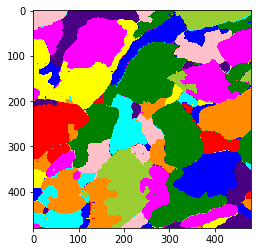

In [6]:
from skimage.color import label2rgb
joint_seg = join_segmentations(best_seg_bpm, gt_raw_testing)
color = label2rgb(joint_seg, image_alpha=0.5)
plt.imshow(color[0])

In [7]:
split_idxs, split_errs, merge_idxs, merge_errs = ev.sorted_vi_components(best_seg_bpm, gt_raw_testing)
split_idxs_sorted, merge_idxs_sorted = np.argsort(split_idxs), np.argsort(merge_idxs)
split_err_unsorted, merge_err_unsorted = split_errs[split_idxs_sorted], merge_errs[merge_idxs_sorted]
split_err_img, merge_err_img = split_err_unsorted[gt_raw_testing], merge_err_unsorted[best_seg_bpm]

In [8]:
cont_table = ev.contingency_table(best_seg, gt_raw_testing)
worst_merge_comps = ev.split_components(merge_idxs[0], num_elems=10, cont=cont_table.T, axis=0)
worst_merge_array = np.array(worst_merge_comps[0:3], dtype=np.int64)
worst_merge_array[:, 0]
np.cumsum(np.array(worst_merge_comps)[:, 1])
extracted_worst_merge_comps = imio.extract_segments(ids=worst_merge_array[:, 0], seg=best_seg)
worst_split_comps = ev.split_components(split_idxs[0], num_elems=10, cont=cont_table.T, axis=0)
worst_split_array = np.array(worst_split_comps[0:3], dtype=np.int64)
worst_split_array[:, 0]
np.cumsum(np.array(worst_split_comps)[:, 1])
extracted_worst_split_comps = imio.extract_segments(ids=worst_split_array[:, 0], seg=best_seg)

In [11]:
merge_idxs_m, merge_errs_m = ev.sorted_vi_components(joint_seg, best_seg_bpm)[2:4]
cont_table_m = ev.contingency_table(joint_seg, best_seg_bpm)
worst_merge_comps_m = ev.split_components(merge_idxs_m[0], num_elems=10, cont=cont_table_m.T, axis=0)
worst_merge_array_m = np.array(worst_merge_comps_m[0:3], dtype=np.int64)
worst_merge_array_m[:, 0]
np.cumsum(np.array(worst_merge_comps_m)[:, 1])
extracted_worst_merge_comps_m = imio.extract_segments(ids=worst_merge_array_m[:, 0], seg=best_seg_bpm)
imio.write_vtk(extracted_worst_merge_comps_m, fn='worst_merge_comps_{short_date}.vtk',spacing=[4, 4, 40])
split_idxs_s, split_errs_s = ev.sorted_vi_components(joint_seg, gt_raw_testing)[0:2]
cont_table_s = ev.contingency_table(joint_seg, gt_raw_testing)
worst_split_comps_s = ev.split_components(split_idxs_s[0], num_elems=10, cont=cont_table_s.T, axis=0)
worst_split_array_s = np.array(worst_split_comps_s[0:3], dtype=np.int64)
worst_split_array_s[:, 0]
np.cumsum(np.array(worst_split_comps_s)[:, 1])
extracted_worst_split_comps_s = imio.extract_segments(ids=worst_split_array_s[:, 0], seg=best_seg_bpm)
imio.write_vtk(extracted_worst_split_comps_s, fn='worst_split_comps_{short_date}.vtk',spacing=[4, 4, 40])

In [ ]:
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2)
ax0.plot(split_vi_array_bpm[:, 1], split_vi_array_bpm[:, 0])
target_segs = np.argsort(np.bincount(seg_stack_large_bpm[9].astype(int).ravel()))[-10:]
ax0.set_title("Split VI")
ax1.set_title("Cumulative VI")
ax1.plot(split_vi_array.sum(axis=1))

In [ ]:
fig, ax = plt.subplots(ncols=2, nrows=2)
ax[0,0].set_title("Worst splits")
ax[0,1].set_title("Wost merges")
ax[1,0].set_title("GT")
ax[1,1].set_title("Best seg")
viz.imshow_magma(split_err_img[12, ...], axis= ax[0,0])
viz.imshow_magma(merge_err_img[12, ...], axis= ax[0,1])
viz.imshow_rand(gt_raw_testing[12, ...], axis=ax[1,0])
viz.imshow_rand(best_seg[12, ...], axis=ax[1,1])

In [ ]:
%lprun -f learn_gala learn_gala()

In [ ]:
# include all the variables in the formal parameter list. 

def write_out_info(stack_of_segs):
    """Write out vtk files of worst merge and worst split comps, and stack of agglomerated segmentations."""
    import datetime
    date = datetime.datetime.now()
    short_date = date.date()
    imio.write_vtk(extracted_worst_merge_comps, fn='worst_merge_comps_{short_date}.vtk',spacing=[4, 4, 40])
    imio.write_vtk(raw_test_slice, fn='raw_test_slice_{short_date}.vtk',spacing=[4, 4, 40])
    imio.write_h5_stack(npy_vol=stack_of_segs, compression='lzf', fn=f'stack_of_segs_{short_date}.h5')

In [ ]:
q = mp.Process(name='rr', target=agglo.Rag, args=(ws_larger_train, bpm[train_slice],), kwargs={'feature_manager':'fc'})
p = mp.Process(name='agglom', target=g_train_larger.learn_agglomerate, args=(gt_larger, fc), kwargs={'classifier':'logistic',})
p.start()
q.start()

In [ ]:
pwd